# Sentiment Analysis of Tweets by Brand <a class="anchor" id="Top"></a>
#### Authors: Eddie Prado, Sally Heinzel, Valeria Viscarra Fossati, and Weston Shuken


<img width="965" alt="Header Image" src="images/sentiment_analysis_header.png">

###### Image by SurveySensum

---

## Table of Contents
* [Overview](#Overview)
* [Business Opportunity](#Business_Opportunity)
* [Data & Methods](#Data_Methods)
* [Data Exploration](#Data_Exploration)
* [Data Modeling](#Data_Modeling)    
    * [Binary Predictor Modeling](#Binary)
        * [Baseline Models](#Binary_Baseline)
        * [Tuned Models](#Binary_Tuned)
    * [Multiclass Predictor Modeling](#Multiclass)
        * [Baseline Models](#Multiclass_Baseline)
        * [Tuned Models](#Multiclass_Tuned)
    * [Added Feature Modeling](#Added_features)
    * [Neural Networks](#Neural_Networks)
    * [Recurrent Neural Networks](#RNN)
* [Final Model](#Final_Model)
* [Results & Evaluation](#Results)
* [Online Application](#Online_App)
* [Recommendations](#Recommendations)
* [Next Steps](#Next_Steps)
* [Contact Us](#Contact)

## Overview <a class="anchor" id="Overview"></a>
Understanding brand and product reputation is difficult when only provided customer survey and review data. However, there is an abundance of social media responses to products and brands on various platforms. With these unofficial reviews and preferences towards products via tweets from Twitter, we can derive an overall sentiment towards your brand and products.

Our company, ViaGoGo, can provide you with a state-of-the-art machine learning model that rates the product and brand sentiment based on users who tweet about your brand. We can provide you with real-time graphs showing the trends of user sentiment towards your brand and products.

This notebook shows the entire process to creating and deploying our ML model for Twitter.



## Business Opportunity <a class="anchor" id="Business_Opportunity"></a>
Companies have little insight into their overall brand reputation on social media platforms. Twitter can provide real-time, accurate analysis of brand reputation based on the sentiment analysis of tweets on Twitter. The word cloud below is an example of how Twitter users are talking about Google and Apple:

Companies have little insight into their overall brand reputation on social media platforms. Twitter can provide real-time, accurate analysis of brand reputation based on the sentiment analysis of tweets on Twitter. The word cloud below is an example of how Twitter users are talking about Google and Apple:

<img width="965" alt="Wordcloud" src="https://user-images.githubusercontent.com/79488205/154748143-17743934-bc8a-40bc-8ec7-86d50fd60665.png">

Our team of experts has built a Machine Learning model that uses Natural Language Processing to distinguish between positive, neutral, and negative sentiment in Tweets. Using Google and Apple mentions on Twitter, we were able to classify sentiment to an 72% accuracy.

This model will be used as an analytics tool for companies to access their products' popularity on Twitter without having to access Twitter API. 


## Data & Methods <a class="anchor" id="Data_Methods"></a>
The dataset comes from Crowdflower via [data.world](https://data.world/crowdflower/brands-and-product-emotions) *Created: August 30, 2013 by Kent Cavender-Bares*. The data contains over 9,000 tweets from Twitter users that evaluated multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed, they were also asked to say which brand or product was the target of that emotion. 

During our exploratory data analysis, we found that the data was not balanced, as shown by the graphs below:

#### All data sentiment count:
<img width="410" alt="all_data_sentiment" src="https://user-images.githubusercontent.com/79488205/154748205-07024099-81f4-4a89-a86f-d5b8271ba599.png">

#### Google & Apple sentiment ratio:
<img width="411" alt="google_apple_sentiment_ratio" src="https://user-images.githubusercontent.com/79488205/154748394-608d0f0a-7ee0-465c-ab95-cbb2dccea9e3.png">

In order to address this imbalance, we first used a binary classifier to predict if a tweet would have a negative or not negative response. We chose to use this binary classification because negative sentiment is much more insightful to a brand versus neutral or positive sentiment. An example of usage could be to monitor if the negative sentiment increases on a particular day, then we can use inferential analysis to find specific tweets that were affecting the rating.

## Exploratory Data Analysis <a class="anchor" id="Data_Exploration"></a>

### Imports

In [1]:
# Importing all needed libraries, packages, and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from nlp_preprocessing import VIA_GoGo
import seaborn as sns
import gensim
import pickle
from textblob import TextBlob

from tensorflow.keras.layers import Dropout, Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Loading the dataset
tweet_df = pd.read_csv('data/db_tweet_emotion.csv', encoding= 'unicode_escape')

In [3]:
# Viewing the dataset
tweet_df.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# Seeing the datatypes and null values in the data
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# Assigning variables of some of the columns for analysis
tweet = tweet_df['tweet_text']
directed = tweet_df['emotion_in_tweet_is_directed_at']
emotion = tweet_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [6]:
# Null values in the dataset per column
tweet_df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [7]:
# Value counts of the emotion expressed in the tweet towards the brand or product
emotion.value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

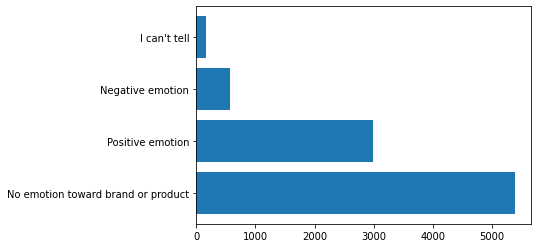

In [8]:
# Plotting the value counts of the emotion towards the products and brands in the dataset
plt.barh(emotion.value_counts().index, emotion.value_counts().values);

In [9]:
# Value counts of the tweet towards the brand or product
directed.value_counts(normalize=True)

iPad                               0.287451
Apple                              0.200851
iPad or iPhone App                 0.142814
Google                             0.130659
iPhone                             0.090246
Other Google product or service    0.089031
Android App                        0.024613
Android                            0.023701
Other Apple product or service     0.010635
Name: emotion_in_tweet_is_directed_at, dtype: float64

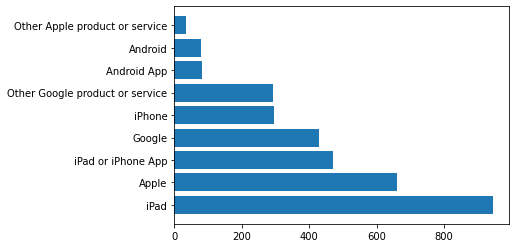

In [10]:
# Plotting the value counts of the products and brands in the dataset
plt.barh(directed.value_counts().index, directed.value_counts().values);

### Clean Up & Tokenize
In this section we will clean up the dataset, tweets, and tokenization.

In [11]:
# Instantiating tokenizer
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")

# Create a list of stopwords in English
sw = stopwords.words('english')

In [12]:
# Appending stop words to the stopwords list of words that appear frequently but don't hold much value
sw.append('link')
sw.append('rt')
sw.append('sxsw')
sw.append('quot')

In [13]:
# instantiating Via_GoGo() -- see viagogo.py for this class
vg = VIA_GoGo()

# Creating a cleaned and shaped dataframe; This gives new columns 'tweet_text_tokenized', 'joined_tokens', 'emotion_num', & 'brand'. 
clean_df = vg.clean_tokenizer(tweet_df, tokenizer, sw)
clean_df # Viewing the clean dataset

,tweet_text,directed_at,emotion,emotion_num,brand,tweet_text_tokenized,joined_tokens
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,-1,Apple,"[wesley83, 3g, iphone, hr, tweeting, rise_aust...",wesley83 3g iphone hr tweeting rise_austin dea...
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,1,Apple,"[jessedee, know, fludapp, awesome, ipad, iphon...",jessedee know fludapp awesome ipad iphone app ...
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,1,Apple,"[swonderlin, wait, ipad, also, sale]",swonderlin wait ipad also sale
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,-1,Apple,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,1,Google,"[sxtxstate, great, stuff, fri, marissa, mayer,...",sxtxstate great stuff fri marissa mayer google...
...,...,...,...,...,...,...,...
9084,"@mention yup, but i don't have a third app yet...",NaN,No emotion toward brand or product,0,Google,"[mention, yup, third, app, yet, android, sugge...",mention yup third app yet android suggestion c...
9085,ipad everywhere. #sxsw {link},iPad,Positive emotion,1,Apple,"[ipad, everywhere]",ipad everywhere
9086,"wave, buzz... rt @mention we interrupt your re...",NaN,No emotion toward brand or product,0,Google,"[wave, buzz, mention, interrupt, regularly, sc...",wave buzz mention interrupt regularly schedule...
9087,"google's zeiger, a physician never reported po...",NaN,No emotion toward brand or product,0,Google,"[google, zeiger, physician, never, reported, p...",google zeiger physician never reported potenti...


In [14]:
# Making columns that shows either negatvie (1) or not negative (0) sentiment 
clean_df['emotion_neg_not'] = clean_df['emotion_num']
clean_df['emotion_neg_not'] = clean_df['emotion_neg_not'].replace({0:1})
clean_df['emotion_neg_not'] = clean_df['emotion_neg_not'].replace({-1:0})

In [15]:
# Viewing the imbalance in the binary column
clean_df.emotion_neg_not.value_counts(normalize=True)

1    0.937287
0    0.062713
Name: emotion_neg_not, dtype: float64

In [16]:
# Compared to the imbalance in the  multiclass dataset
clean_df.emotion_num.value_counts(normalize=True)

 0    0.609638
 1    0.327649
-1    0.062713
Name: emotion_num, dtype: float64

In [17]:
# Creating new DataFrame that does not include neutral tweets
binary_df = clean_df[clean_df.emotion_num != 0]
# Viewing balance of classes when dropped neutral tweets
binary_df.emotion_num.value_counts(normalize=True)

 1    0.839346
-1    0.160654
Name: emotion_num, dtype: float64

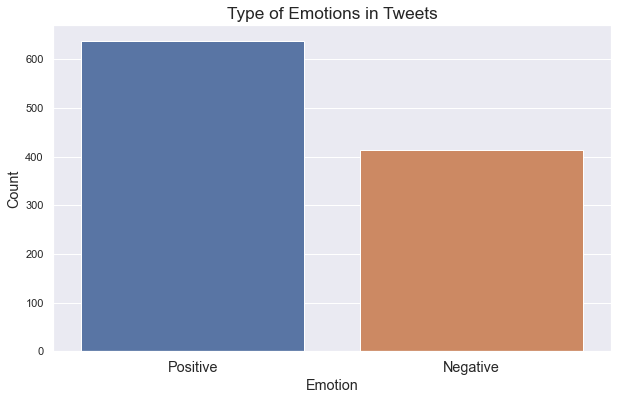

In [18]:
# Visualize the counts of each emotion type
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=binary_df, 
    x="directed_at",
    order=binary_df.brand.value_counts().index)

ax.set_title('Type of Emotions in Tweets',fontsize='x-large')
ax.set_xlabel('Emotion',fontsize='large')
ax.set_ylabel('Count',fontsize='large')
plt.xticks(range(2), ['Positive','Negative'],fontweight='light', fontsize='large')

plt.show();

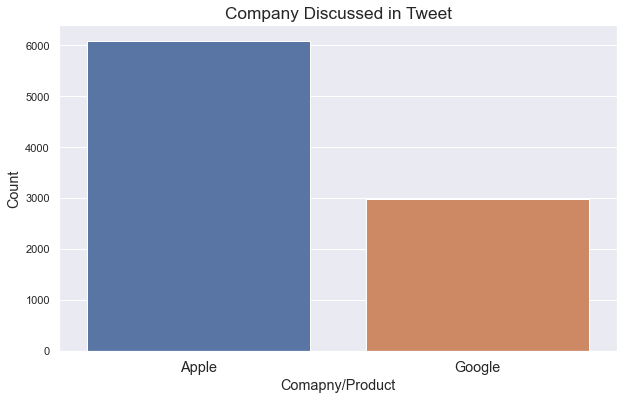

In [19]:
# Visualize the counts of each company discussed in tweets
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(
   data=clean_df,
   x='brand', order=clean_df['brand'].value_counts().index)
ax.set_title('Company Discussed in Tweet', fontsize='x-large')
ax.set_xlabel('Comapny/Product',fontsize='large')
ax.set_xticklabels(ax.get_xticklabels(),fontweight='light', fontsize='large')
ax.set_ylabel('Count',fontsize='large')
plt.show();


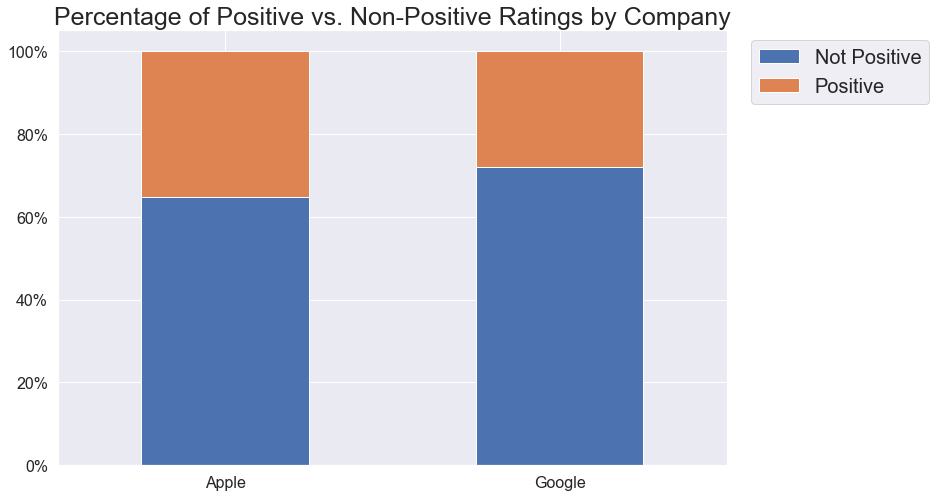

In [20]:
# Visualize company/product mentioned by positive/non-positive emotion
import matplotlib.ticker as mtick
clean_df['pos_neg_neutral']=clean_df['emotion_num'] == 1
clean_df.groupby(['brand','pos_neg_neutral']).size().groupby(level=0).apply(
   lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, figsize=(12,8), legend='reverse')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor= (1.02, 1),prop = {'size' : 20},labels=('Not Positive', 'Positive'))
plt.xlabel('')
plt.xticks(fontsize=16,rotation=0,fontweight='light')
plt.yticks(fontsize=16)
plt.title('Percentage of Positive vs. Non-Positive Ratings by Company', size=25)
plt.show();

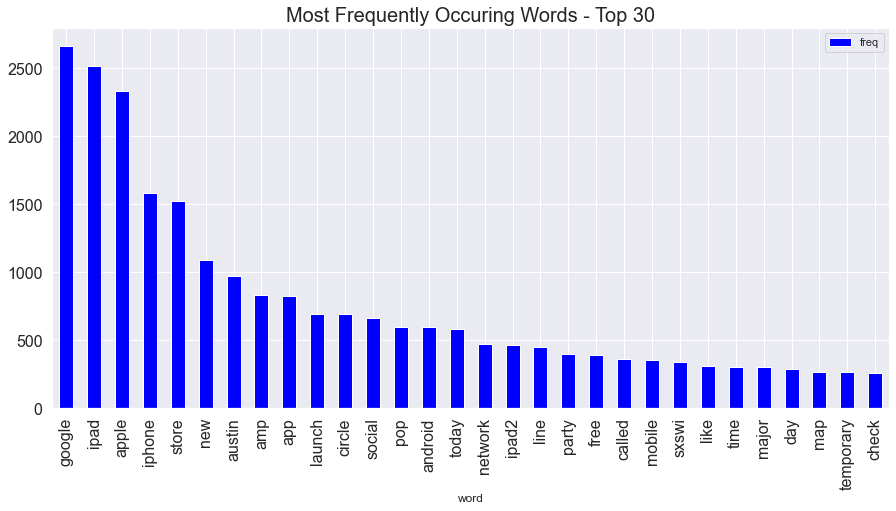

In [21]:
#graph frequency of top 30 words
from sklearn.feature_extraction import text
#add custom words to stop word list
stop_words = text.ENGLISH_STOP_WORDS.union(['sxsw','mention','link','rt'])
cv = CountVectorizer(stop_words = stop_words)
words = cv.fit_transform(clean_df.joined_tokens)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title('Most Frequently Occuring Words - Top 30', size=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

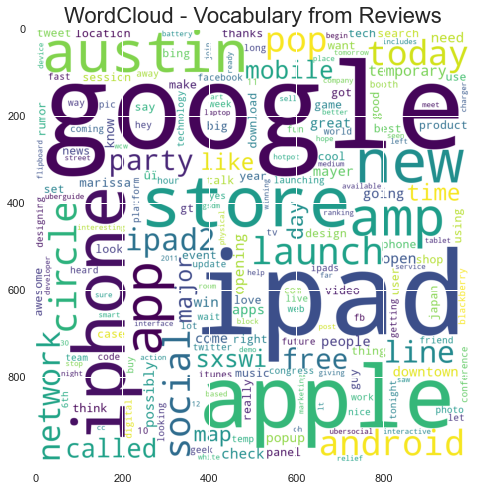

In [22]:
# A word cloud of the tokenized words
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title('WordCloud - Vocabulary from Reviews', fontsize = 22);

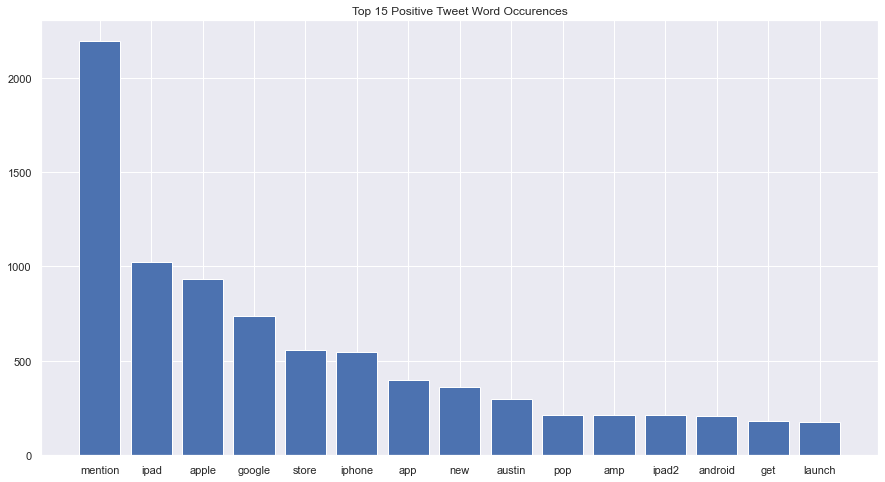

In [23]:
# Viewing top 15 words in only positive emotion tweets
frequency_dist_positive = FreqDist(clean_df["tweet_text_tokenized"][clean_df["emotion_num"] == 1].explode())

top_ten = list(zip(*frequency_dist_positive.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts)
plt.title('Top 15 Positive Tweet Word Occurences');

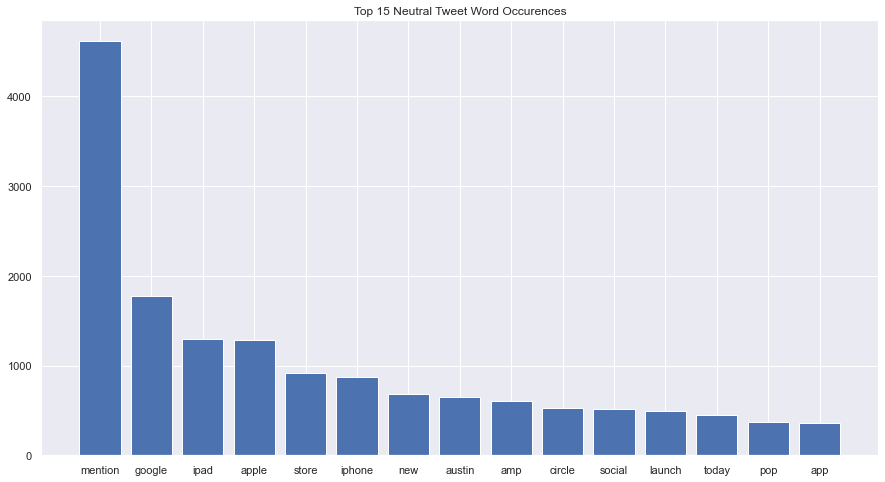

In [24]:
# Viewing top 15 words in only neutral emotion tweets
frequency_dist_neutral = FreqDist(clean_df["tweet_text_tokenized"][clean_df["emotion_num"] == 0].explode())

top_ten = list(zip(*frequency_dist_neutral.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts)
plt.title('Top 15 Neutral Tweet Word Occurences');

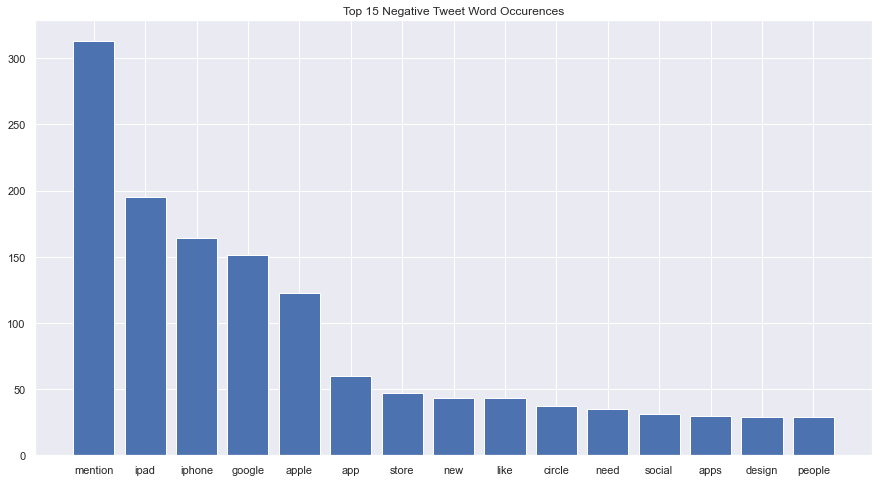

In [25]:
# Viewing top 15 words in only negative emotion tweets
frequency_dist_negative = FreqDist(clean_df["tweet_text_tokenized"][clean_df["emotion_num"] == -1].explode())

top_ten = list(zip(*frequency_dist_negative.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts)
plt.title('Top 15 Negative Tweet Word Occurences');

## Data Modeling <a class="anchor" id="Data_Modeling"></a>
First we will fit our binary prediction models on the negative and not negative predictors.
Then we will fit our muliclass prediction models on the positive, negative, and neutral predictors.

### Binary Data Predictor <a class="anchor" id="Binary"></a>

#### Baseline  <a class="anchor" id="Binary_Baseline"></a>

In [26]:
# Baseline Linear Support Vector Machine
sgd = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier()),
              ])

# Baseline Naive Bayes
naive = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

# Baseline Logistic Regression
lin_reg = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])
# Baseline Random Forest
rfc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier()),
              ])

# List of baseline models
baseline_models = [sgd, naive, lin_reg, rfc]


In [27]:
# Creating empty metric table for attaching scores of model performence.
metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Test Accuracy', 'Type'])

In [28]:
# Looping through baseline models and attaching scores to metric table
# This run_model() function is part of our ViaGoGo class in viagogo.py
for model in baseline_models:   
    row = vg.run_model(model, metric_table, clean_df['joined_tokens'], clean_df['emotion_neg_not'], 'binary_baseline', join_str=False)
    metric_table = pd.concat([row])

metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline,0.9407,0.9397,binary_baseline
1,MultinomialNB()binary_baseline,0.9391,0.9353,binary_baseline
2,LogisticRegression()binary_baseline,0.9382,0.9340,binary_baseline
3,RandomForestClassifier()binary_baseline,0.9425,0.9406,binary_baseline


#### Tuned  <a class="anchor" id="Binary_Tuned"></a>

In [29]:
# Tuned Linear Support Vector Machine - w/ bigrams
sgd_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier())
              ])
# Tuned Naive Bayes - w/ bigrams
naive_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
# Tuned Logistic Regression - w/ bigrams
lin_reg_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(n_jobs=5)),
              ])
# Tuned Random Forest - w/ bigrams
rfc_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_depth=800, n_estimators=100)),
              ])

# List of tuned models w/ bigrams
baseline_tuned_models = [sgd_tuned, naive_tuned, lin_reg_tuned, rfc_tuned]

In [30]:
# Looping through tuned models and attaching scores to metric table
for model in baseline_tuned_models:   
    row = vg.run_model(model, metric_table, clean_df['joined_tokens'], clean_df['emotion_neg_not'], 'binary_tuned', join_str=False)
    metric_table = pd.concat([row])

metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline,0.9407,0.9397,binary_baseline
1,MultinomialNB()binary_baseline,0.9391,0.9353,binary_baseline
2,LogisticRegression()binary_baseline,0.9382,0.9340,binary_baseline
3,RandomForestClassifier()binary_baseline,0.9425,0.9406,binary_baseline
4,SGDClassifier()binary_tuned,0.9422,0.9424,binary_tuned
5,MultinomialNB()binary_tuned,0.9390,0.9358,binary_tuned
6,LogisticRegression()binary_tuned,0.9382,0.9344,binary_tuned
7,RandomForestClassifier()binary_tuned,0.9422,0.9415,binary_tuned


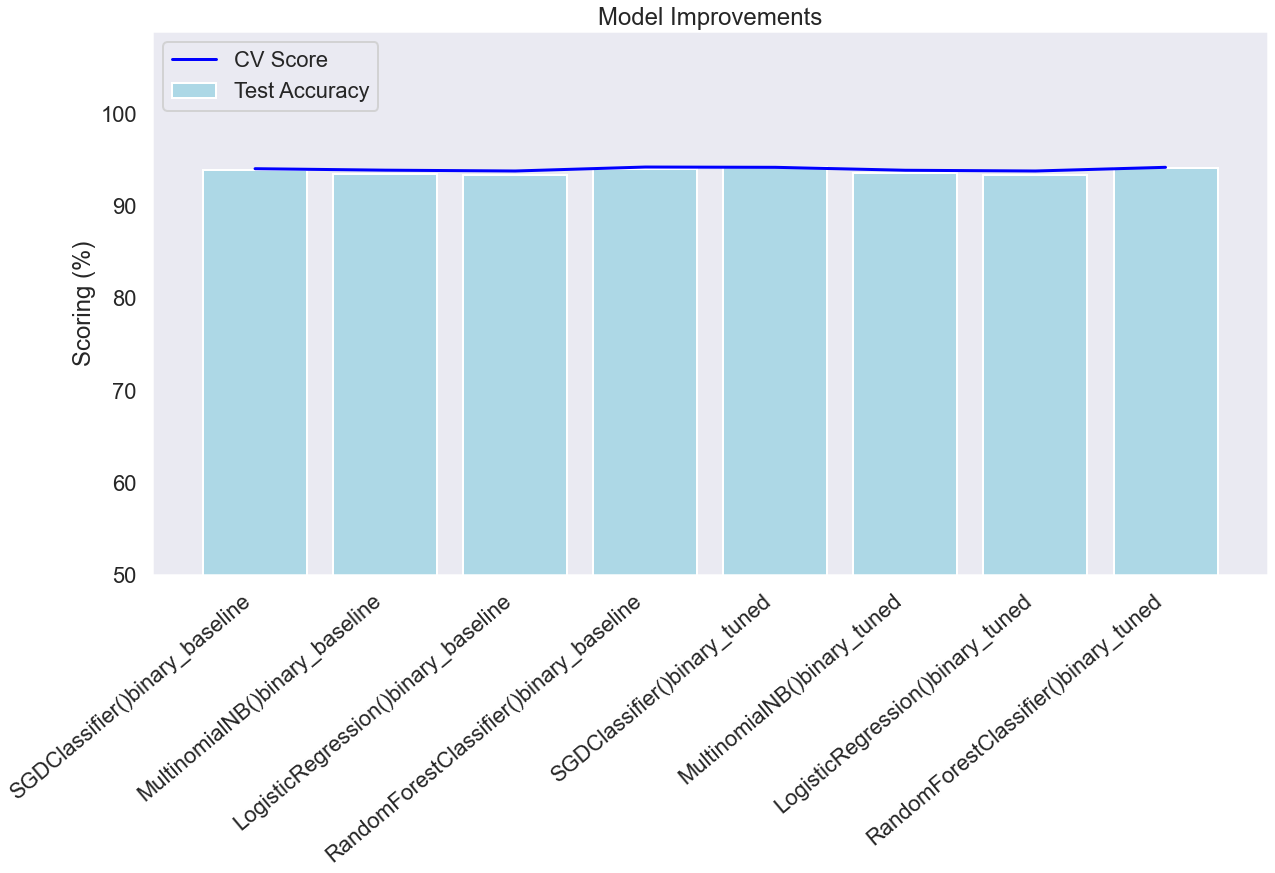

In [31]:
# Plotting all the binary models
vg.plot_models(metric_table)

#### Binary Modeling Takeaways:
- The accuracy did not improve much over the imbalance in the dataset of 93.7% not negative values.
- We will proceed with adding the neutral values back in for multiclass predictions.

### Multiclass Data Predictor  <a class="anchor" id="Multiclass"></a>

#### Baseline  <a class="anchor" id="Multiclasss_Baseline"></a>

In [32]:
# Baseline Linear Support Vector Machine 
sgd_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier())
              ])
# Baseline Naive Bayes
naive_mc = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
# Baseline Logistic Regression
lin_reg_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(solver='newton-cg', n_jobs=5)),
              ])
# Baseline Random Forest
rfc_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_depth=800, n_estimators=100, class_weight='balanced')),
              ])

# List of multiclass baseline models
multiclass_models = [sgd_mc, naive_mc, lin_reg_mc, rfc_mc]

In [33]:
# New metric table for multiclass models
metric_table_multi = pd.DataFrame(columns=['Model', 'CV Score', 'Test Accuracy', 'Type'])

In [34]:
# Looping through baseline models and attaching scores to metric table
for model in multiclass_models:   
    row = vg.run_model(model, metric_table_multi, clean_df['joined_tokens'], clean_df['emotion_num'], 'baseline_multiclass', join_str=False)
    metric_table_multi = pd.concat([row])

metric_table_multi

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.6724,0.7044,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.6492,0.6727,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.6796,0.6991,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.6668,0.6885,baseline_multiclass


#### Tuned  <a class="anchor" id="Multiclass_Tuned"></a>

In [35]:
# Baseline Linear Support Vector Machine
sgd_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier())
              ])
# Baseline Naive Bayes
naive_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
# Baseline Logistic Regression
lin_reg_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(solver='newton-cg', n_jobs=5)),
              ])
# Baseline Random Forest
rfc_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_depth=800, n_estimators=100, class_weight='balanced')),
              ])

# List of multiclass tuned models w/ bigrams
multiclass_models_tuned = [sgd_tuned_mc, naive_tuned_mc, lin_reg_tuned_mc, rfc_tuned_mc]

In [36]:
# Looping through tuned models and attaching scores to metric table
for model in multiclass_models_tuned:   
    row = vg.run_model(model, metric_table_multi, clean_df['joined_tokens'], clean_df['emotion_num'], 'tuned_multiclass', join_str=False)
    metric_table_multi = pd.concat([row])

metric_table_multi

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.6724,0.7044,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.6492,0.6727,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.6796,0.6991,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.6668,0.6885,baseline_multiclass
4,SGDClassifier()tuned_multiclass,0.6718,0.7022,tuned_multiclass
5,MultinomialNB()tuned_multiclass,0.6492,0.6727,tuned_multiclass
6,LogisticRegression()tuned_multiclass,0.6796,0.6991,tuned_multiclass
7,RandomForestClassifier()tuned_multiclass,0.6681,0.6824,tuned_multiclass


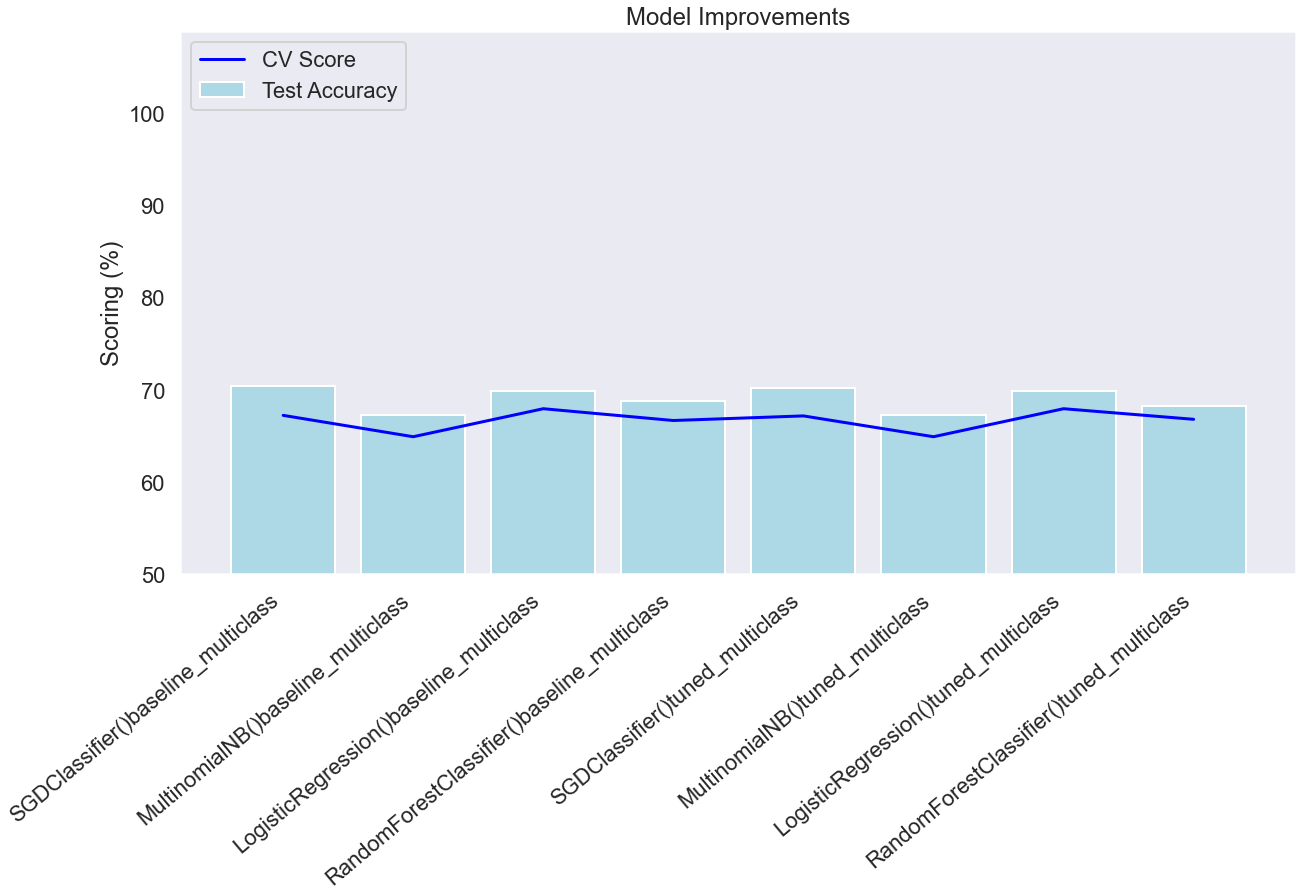

In [37]:
# Plotting all the multiclass models
vg.plot_models(metric_table_multi)

#### Multiclass Modeling Takeaways:
- The accuracy is lower than the binary models which is expected given the imbalance in the dataset. 
- This is performing over 10% better than always predicting the most prevelant class.
- Results may vary slightly because we do not have a random state provided for each classifier.
- We will try some more strategies for modeling below.

### Adding Features <a class="anchor" id="Added_Features"></a>
In this section, we add some features to out dataset to see if it will improve performence.

In [38]:
# Using TextBlob for getting polarity score
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

clean_df['TextBlob_Polarity'] = clean_df['joined_tokens'].apply(getPolarity)

In [39]:
# Using Afinn to get sentiment score
from afinn import Afinn
afinn = Afinn(language='en')
def getAffinscore(text):
    return afinn.score(text)
clean_df['Affin_score'] = clean_df['joined_tokens'].apply(getAffinscore)

In [40]:
# Viewing these features
sentiment_features = clean_df.loc[:,['TextBlob_Polarity', 'Affin_score']]
sentiment_features

,TextBlob_Polarity,Affin_score
0,-0.200000,-3.0
1,0.466667,7.0
2,0.000000,0.0
3,0.000000,2.0
4,0.800000,3.0
...,...,...
9084,0.000000,0.0
9085,0.000000,0.0
9086,0.000000,-1.0
9087,0.000000,0.0


In [41]:
# Joining these features to the dataframs and vectorizing for modeling
clean_df['joined_tokens'] = clean_df['joined_tokens'].str.replace('\d+', '')

X = clean_df['joined_tokens']
countvec = CountVectorizer(min_df=5, ngram_range=(1,2), stop_words='english', strip_accents='unicode')


X_vec = countvec.fit_transform(X)

X_df = pd.DataFrame(X_vec.toarray(), columns=countvec.get_feature_names())
preprocess_features = sentiment_features.join(X_df, on=X_df.index)

In [42]:
# Modeling for new features
sgd_feat = SGDClassifier()

rfc_feat = RandomForestClassifier(max_depth=100, n_estimators=100, class_weight='balanced')

feature_models = [sgd_feat, rfc_feat]

In [43]:
# Looping through new features models and attaching scores to metric table
for model in feature_models:   
    row = vg.run_model(model, metric_table_multi, preprocess_features, clean_df['emotion_num'], 'features_multiclass', join_str=False, pipeline=False)
    metric_table_multi = pd.concat([row])

metric_table_multi

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.6724,0.7044,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.6492,0.6727,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.6796,0.6991,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.6668,0.6885,baseline_multiclass
4,SGDClassifier()tuned_multiclass,0.6718,0.7022,tuned_multiclass
5,MultinomialNB()tuned_multiclass,0.6492,0.6727,tuned_multiclass
6,LogisticRegression()tuned_multiclass,0.6796,0.6991,tuned_multiclass
7,RandomForestClassifier()tuned_multiclass,0.6681,0.6824,tuned_multiclass
8,SGDClassifier()features_multiclass,0.6636,0.6810,features_multiclass
9,RandomForestClassifier()features_multiclass,0.6862,0.7022,features_multiclass


### Word2Vec <a class="anchor" id="Word2Vec"></a>

In [44]:
# Using Word2Vec Strategy for improving score -- code shoutout https://github.com/prateekjoshi565/twitter_sentiment_analysis/blob/master/code_sentiment_analysis.ipynb
model_w2v = gensim.models.Word2Vec(
            sentences=clean_df.tweet_text_tokenized,
            vector_size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(clean_df.tweet_text_tokenized, total_examples=len(clean_df.tweet_text_tokenized), epochs=20)

(1393639, 1868820)

In [45]:
# Seeing similarity score to different terms
model_w2v.wv.most_similar(positive="iphone")

[('wew', 0.4888468086719513),
 ('desperate', 0.47840866446495056),
 ('pushed', 0.47071462869644165),
 ('yayrt', 0.464505136013031),
 ('handy', 0.4636964499950409),
 ('merchant', 0.4623625576496124),
 ('vufinders', 0.4619499444961548),
 ('loaded', 0.4540192484855652),
 ('purse', 0.44957587122917175),
 ('crash', 0.44644859433174133)]

In [46]:
model_w2v.wv.most_similar(positive="awesome")

[('browse', 0.49824878573417664),
 ('unadulterated', 0.479574978351593),
 ('daniel', 0.4564526677131653),
 ('breakfast', 0.44409245252609253),
 ('sister', 0.4435979127883911),
 ('johnston', 0.4353983998298645),
 ('mystery', 0.43290260434150696),
 ('awesomeness', 0.4281647205352783),
 ('passport', 0.427977055311203),
 ('electronics', 0.42618444561958313)]

In [47]:
# Creating function for creating vector of the tokens
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [48]:
# # Fixing index to be number
# clean_df.reset_index(inplace=True, drop=True)

In [49]:
# Putting it all together into a word2vec dataframe
wordvec_arrays = np.zeros((len(clean_df.tweet_text_tokenized), 200))

for i in range(len(clean_df.emotion_num)):
    wordvec_arrays[i,:] = word_vector(clean_df.tweet_text_tokenized[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape  # printing shape 

(9089, 200)

In [50]:
# Modeling for Word2Vec
sgd_word2vec = SGDClassifier()
rfc_word2vec = RandomForestClassifier(class_weight='balanced')

word2vec_models = [sgd_word2vec, rfc_word2vec]

In [51]:
# Looping through Word2Vec models and attaching scores to metric table
for model in word2vec_models:   
    row = vg.run_model(model, metric_table_multi, wordvec_df, clean_df['emotion_num'], 'word2vec', join_str=False, pipeline=False)
    metric_table_multi = pd.concat([row])
    
metric_table_multi


,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.6724,0.7044,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.6492,0.6727,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.6796,0.6991,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.6668,0.6885,baseline_multiclass
4,SGDClassifier()tuned_multiclass,0.6718,0.7022,tuned_multiclass
5,MultinomialNB()tuned_multiclass,0.6492,0.6727,tuned_multiclass
6,LogisticRegression()tuned_multiclass,0.6796,0.6991,tuned_multiclass
7,RandomForestClassifier()tuned_multiclass,0.6681,0.6824,tuned_multiclass
8,SGDClassifier()features_multiclass,0.6636,0.6810,features_multiclass
9,RandomForestClassifier()features_multiclass,0.6862,0.7022,features_multiclass


### Neural Network  <a class="anchor" id="Neural_Network"></a>

In [52]:
# Creating new column of targets for NN
clean_df['emotion_num_nn'] = clean_df['emotion_num']

In [53]:
# Need to replace the -1 with 2 for negative sentiment
clean_df['emotion_num_nn'] = clean_df['emotion_num_nn'].replace(-1, 2)

In [54]:
# Isolating X and y variables
X = clean_df['joined_tokens']
y =  clean_df['emotion_num_nn']

In [55]:
# Splitting to test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size= 0.25,
                                                    random_state= 5)

In [56]:
# Vectorizing and transforming with TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2))

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# View the shapes of X variables
print('Shape of train features tensor:', X_train_vec.shape)
print('Shape of test features tensor:', X_test_vec.shape)

# View the shapes of y variables
print('Shape of train label tensor:', y_train.shape)
print('Shape of test label tensor:', y_test.shape)

Shape of train features tensor: (6816, 38060)
Shape of test features tensor: (2273, 38060)
Shape of train label tensor: (6816,)
Shape of test label tensor: (2273,)


In [57]:
# Creating Neural Network Model
model = Sequential()
model.add(layers.Dense(300, input_dim=(38060), activation='relu' ))
model.add(Dropout(.4))
model.add(layers.Dense(3, activation='softmax'))

2022-02-18 15:49:15.649322: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-18 15:49:15.650989: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [58]:
# Compiling and running Neural Network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_vec, y_train, epochs=6, batch_size=200, validation_split=.20, verbose=1)

Train on 5452 samples, validate on 1364 samples
Epoch 1/6
5452/5452 [==============================] - 6s 1ms/sample - loss: 0.9817 - accuracy: 0.5981 - val_loss: 0.8416 - val_accuracy: 0.6312
Epoch 2/6
5452/5452 [==============================] - 5s 858us/sample - loss: 0.7403 - accuracy: 0.6289 - val_loss: 0.7408 - val_accuracy: 0.6547
Epoch 3/6
5452/5452 [==============================] - 5s 846us/sample - loss: 0.5661 - accuracy: 0.8056 - val_loss: 0.7059 - val_accuracy: 0.6913
Epoch 4/6
5452/5452 [==============================] - 5s 847us/sample - loss: 0.3980 - accuracy: 0.8729 - val_loss: 0.7168 - val_accuracy: 0.6796
Epoch 5/6
5452/5452 [==============================] - 5s 867us/sample - loss: 0.2679 - accuracy: 0.9156 - val_loss: 0.7477 - val_accuracy: 0.6796
Epoch 6/6
5452/5452 [==============================] - 4s 798us/sample - loss: 0.1901 - accuracy: 0.9422 - val_loss: 0.7857 - val_accuracy: 0.6730


In [59]:
# Printing test score accuracy
results = model.evaluate(X_test_vec, y_test, batch_size=10)
print("test loss, test acc:", results)

2273/2273 [==============================] - 2s 769us/sample - loss: 0.7683 - accuracy: 0.6854
test loss, test acc: [0.7682551467964107, 0.68543774]


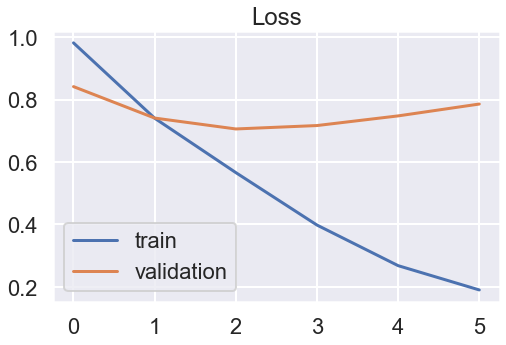

In [60]:
# Plotting loss of train and validation sets by epochs
plt.figure(figsize=(8,5))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

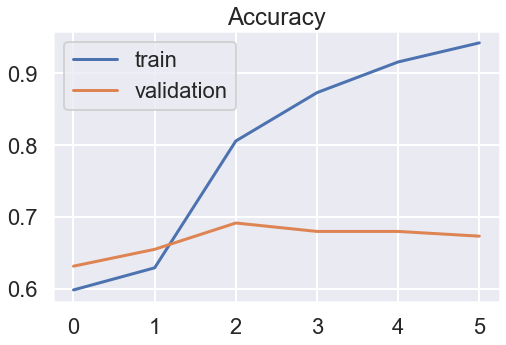

In [61]:
# Plotting accuracy of train and validatio sets by epochs
plt.figure(figsize=(8,5))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

In [62]:
# Appending results to metric table
NN_dict = {'Model': 'NeuralNetwork', 
            'CV Score': max(history.history['val_accuracy']),
            'Test Accuracy': results[1],
            'Type': 'multiclass_NN'}
NN_row = pd.DataFrame(NN_dict, index=[0])

metric_table_multi = pd.concat([metric_table_multi, NN_row], ignore_index=True)

### Recurrent Neural Network w/ LSTM <a class="anchor" id="RNN"></a>

In [63]:
# Creating variables for out Recurrent Neural Network -- Code shoutout to Susan Li https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

# Instantiating Tokenizer and fiting to 'joined_tokens'
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(clean_df['joined_tokens'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8531 unique tokens.


In [64]:
# Tokenizing strings and padding sequeneces to the same length -- "MAX_SEQUENCE_LENGTH"
X = tokenizer.texts_to_sequences(clean_df['joined_tokens'].values) # Transforms each text in texts to a sequence of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape) # Printing shape of X

Shape of data tensor: (9089, 250)


In [65]:
# Creating dummy variables for sentiment values of 'emotion_num'
y = pd.get_dummies(clean_df['emotion_num']).values
print('Shape of label tensor:', y.shape) # Printing Y shape

Shape of label tensor: (9089, 3)


In [66]:
# Splitting to test and training sets -- printing shapes of each variable
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2, random_state=5)
print(X_train.shape,Y_train.shape) 
print(X_test.shape,Y_test.shape)

(7271, 250) (7271, 3)
(1818, 250) (1818, 3)


In [67]:
# Instantiating Sequential Model 
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(4))
model.add(Dense(3, activation='softmax'))

# Compiling and running Recurrent Neural Network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Defining epochs and batch_size
epochs = 6
batch_size = 200

# Fitting the model
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', 
                                                                  patience=3, min_delta=0.0001)])

Train on 6543 samples, validate on 728 samples
Epoch 1/6


2022-02-18 15:49:49.092230: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_5215_5397' and '__inference___backward_standard_lstm_5516_6001_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_6153' both implement 'lstm_aeaf3925-6842-41c6-86c8-dbfc65d1db5c' but their signatures do not match.


6400/6543 [============================>.] - ETA: 0s - loss: 1.0039 - accuracy: 0.5972

2022-02-18 15:50:03.057885: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_6453' and '__inference_standard_lstm_6453_specialized_for_sequential_1_lstm_StatefulPartitionedCall_at___inference_distributed_function_6831' both implement 'lstm_4c7693df-a019-447e-acaf-2c03a730e70c' but their signatures do not match.


6543/6543 [==============================] - 16s 2ms/sample - loss: 1.0028 - accuracy: 0.5961 - val_loss: 0.9197 - val_accuracy: 0.5989
Epoch 2/6
6543/6543 [==============================] - 13s 2ms/sample - loss: 0.8555 - accuracy: 0.6098 - val_loss: 0.8469 - val_accuracy: 0.6003
Epoch 3/6
6543/6543 [==============================] - 13s 2ms/sample - loss: 0.7760 - accuracy: 0.6242 - val_loss: 0.8042 - val_accuracy: 0.6264
Epoch 4/6
6543/6543 [==============================] - 14s 2ms/sample - loss: 0.6970 - accuracy: 0.6988 - val_loss: 0.7833 - val_accuracy: 0.6346
Epoch 5/6
6543/6543 [==============================] - 14s 2ms/sample - loss: 0.6220 - accuracy: 0.7613 - val_loss: 0.7700 - val_accuracy: 0.6566
Epoch 6/6
6543/6543 [==============================] - 16s 2ms/sample - loss: 0.5544 - accuracy: 0.7931 - val_loss: 0.7662 - val_accuracy: 0.6593


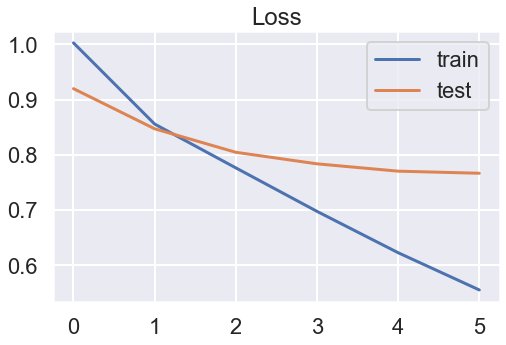

In [68]:
# Plotting loss of train and validation sets by epochs
plt.figure(figsize=(8,5))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

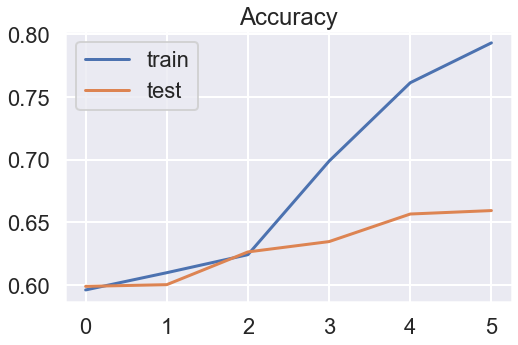

In [69]:
# Plotting accuracy of train and validatio sets by epochs
plt.figure(figsize=(8,5))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [70]:
# Appending results to metric table
RNN_dict = {'Model': 'RecurrentNeuralNetwork', 
            'CV Score': max(history.history['val_accuracy']),
            'Test Accuracy': 0,
            'Type': 'multiclass_NN'}
RNN_row = pd.DataFrame(RNN_dict, index=[0])

metric_table_multi = pd.concat([metric_table_multi, RNN_row], ignore_index=True)

In [71]:
# Viewing all the models
metric_table_multi

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.672400,0.704400,baseline_multiclass
1,MultinomialNB()baseline_multiclass,0.649200,0.672700,baseline_multiclass
2,LogisticRegression()baseline_multiclass,0.679600,0.699100,baseline_multiclass
3,RandomForestClassifier()baseline_multiclass,0.666800,0.688500,baseline_multiclass
4,SGDClassifier()tuned_multiclass,0.671800,0.702200,tuned_multiclass
5,MultinomialNB()tuned_multiclass,0.649200,0.672700,tuned_multiclass
6,LogisticRegression()tuned_multiclass,0.679600,0.699100,tuned_multiclass
7,RandomForestClassifier()tuned_multiclass,0.668100,0.682400,tuned_multiclass
8,SGDClassifier()features_multiclass,0.663600,0.681000,features_multiclass
9,RandomForestClassifier()features_multiclass,0.686200,0.702200,features_multiclass


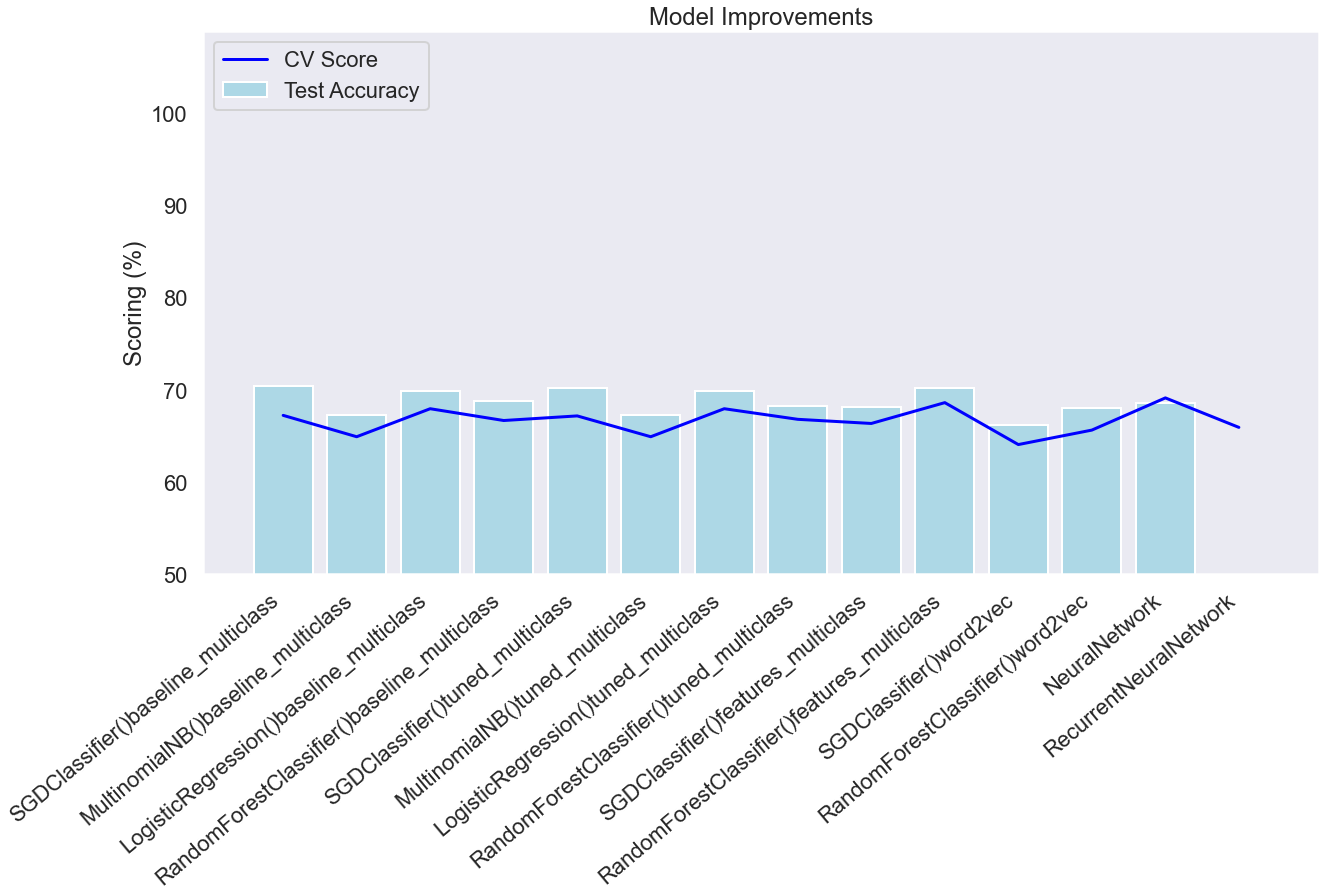

In [72]:
# Plotting all the multiclass models
vg.plot_models(metric_table_multi)

#### Modeling Strategies Takeaways:
- With all of the work done, we still have great results from out SGDClassifier.
- We will go with this model for the final model, since the accuracy score is high, but also the computing power and time to run is quicker than most other models.

### Final Model <a class="anchor" id="Final_Model"></a>

For our final model, we chose to use the top performing on the multiclass in order to predict any of the three classes of tweet sentiment.

In [73]:
# Finding our top MULTICLASS MODEL
metric_table_multi.sort_values(by=['Test Accuracy'], ascending=False)

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass,0.672400,0.704400,baseline_multiclass
4,SGDClassifier()tuned_multiclass,0.671800,0.702200,tuned_multiclass
9,RandomForestClassifier()features_multiclass,0.686200,0.702200,features_multiclass
2,LogisticRegression()baseline_multiclass,0.679600,0.699100,baseline_multiclass
6,LogisticRegression()tuned_multiclass,0.679600,0.699100,tuned_multiclass
3,RandomForestClassifier()baseline_multiclass,0.666800,0.688500,baseline_multiclass
12,NeuralNetwork,0.691349,0.685438,multiclass_NN
7,RandomForestClassifier()tuned_multiclass,0.668100,0.682400,tuned_multiclass
8,SGDClassifier()features_multiclass,0.663600,0.681000,features_multiclass
11,RandomForestClassifier()word2vec,0.656400,0.680200,word2vec


In [74]:
# Splitting new variables into train and test sets to evaluate our final model.
X_train, X_test, y_train, y_test = train_test_split(clean_df['joined_tokens'], 
                                                    clean_df['emotion_num'], 
                                                    test_size= 0.25,
                                                    random_state= 5)

In [75]:
# Creating variables for the final predictions and final true values
final_preds = sgd_tuned_mc.predict(X_test)
final_trues = y_test

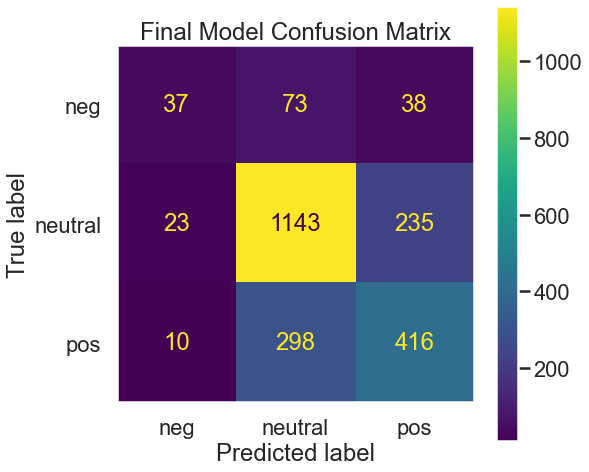

In [76]:
# Plotting the confusion matrix for the final model
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sgd_tuned_mc, X_test, y_test, ax=ax, display_labels=['neg', 'neutral', 'pos'])
plt.title('Final Model Confusion Matrix')
plt.grid(False)
plt.show();

In [77]:
# Saving the model for usage in our application -- app.py
pickle.dump(sgd_tuned_mc, open('final_clf.pkl', 'wb'))

## Results & Evaluation <a class="anchor" id="Results"></a>

We built multiclass models to predict whether tweets were positive, neutral and negative. Our baseline model has a 61%  accuracy which is derived by always predicting the neutral class (given its imbalance). We increased this score using machine learning models, specifically Naive Bayes, Random Forest, Neural Network, and SGD Classifier, finally arriving at our best model at ~72% accuracy.

<img width="405" alt="multiclass_models" src="https://user-images.githubusercontent.com/79488205/154748935-457f5a4e-bf1e-4199-9a80-f0d99913e04d.png">


## Online Application

We created an online application to demo the model's performance. The user can input a sample tweet and click the 'GoGo!' button, which will then return a sentiment score for the sample tweet of Positive, Negative, or Neutral.

<img width="1200" alt="App Photo" src="images/app_photo.png">


To demo the product, please click on our logo or visit this [link]().

## Recommendations <a class="anchor" id="Recommendations"></a>
Being competitive in the 21st century means utilizing 21st-century tools. ViaGogo’s Twitter Sentiment Analysis, built using natural language processing, offers Twitter an opportunity to give their brand users an advantage in the marketplace. This product enables businesses to capture public reactions about their company and products in a far more timely and authentic manner than focus groups or surveys. It collects and analyzes real-time reactions in order for businesses to make effective decisions.

The Twitter Sentiment Analysis adds value to businesses in 3 main ways:
-	Brand Perception – track what people are saying about a company/product in real-time within a mercurial social media environment;
-	Market Research – identify and explore the sentiments directed at one’s competitors in order to develop strategies based on their successes and struggles;
-	Customer Service – pinpoint which brands, locations, or services are thriving in customer satisfaction and which ones need the most urgent attention.

By adopting ViaGogo’s Twitter Sentiment Analysis and offering it as a service for corporate users, Twitter will increase its utility and make itself an indispensable part of the modern business landscape.


## Next Steps <a class="anchor" id="Next_Steps"></a>
ViaGogo in currently working on some new applications for its Twitter Sentiment Analysis. One product in development is the Positivity Rater. This tool gives users a positivity rating based on the analysis of the account’s past tweets. This can be useful to increase engagement among Twitters users. With so many people turned off by negative and harmful content, the Positivity Rater allows an individual to gauge how positive someone is when considering whether or not to follow them. We believe this will boost user activity and retain those who otherwise may stop using Twitter due to so much unwanted, pernicious content.

Another area ViaGoGo is actively working on is the creation of dashboards, which allow users to easily visualize sentiment analysis both in real-time and longitudinally. These dashboards will filter data on different dimensions, such as time frame, location, and product/service. It will also facilitate easy comparison of a given metric (for example, comparing the sentiments expressed towards 2 different branches or how sentiment about a product compares to this time last year).

Finally, ViaGoGo is already in production of a web app that allows users to write a tweet and see its sentiment rating before publishing it. This will ensure that the author strikes the appropriate tone with their tweet and can prevent thoughtless or poorly constructed tweets from entering the public domain. This feature will be valued by social media managers sitewide.

---
<h2><center>Brought to you by</center></h2>
<center><img width="175" alt="Header Image" align="center" src="images/ViaGoGo_logo.png" ></center>

---


#### For more information <a class="anchor" id="Contact"></a>
Please contact the contributors to this analysis: 
[Eddie Prado]() |
[Sally Heinzel]() |
[Valeria Viscarra Fossati](https://www.linkedin.com/in/valeria-vf/) |
[Weston Shuken](https://www.linkedin.com/in/westonshuken/)

[Return to top](#Top)